In [1]:
!pip install torchmetrics
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.5/963.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 28.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms,utils
from torchmetrics.classification import Accuracy, Precision, Recall, F1Score, ConfusionMatrix
import cv2
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
import timm

In [3]:
import kagglehub

path = kagglehub.dataset_download("mariaherrerot/aptos2019")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/aptos2019


In [4]:
list_dir = os.listdir(path)
print(list_dir)

['val_images', 'train_images', 'valid.csv', 'test.csv', 'train_1.csv', 'test_images']


In [5]:
train_images=path+'/train_images'*2
train_labels=pd.read_csv(path+'/train_1.csv')
valid_images=path+'/val_images'*2
valid_labels=pd.read_csv(path+'/valid.csv')
test_images=path+'/test_images'*2
test_labels=pd.read_csv(path+'/test.csv')

In [6]:
combined_data=pd.concat([train_labels,valid_labels,test_labels]).reset_index(drop=True)

In [7]:
combined_data.head()

,id_code,diagnosis
0,1ae8c165fd53,2
1,1b329a127307,1
2,1b32e1d775ea,4
3,1b3647865779,0
4,1b398c0494d1,0


In [8]:
combined_data['diagnosis'].value_counts()

,count
diagnosis,
0,1805
2,999
1,370
4,295
3,193


In [9]:
combined_data.shape

(3662, 2)

<Axes: xlabel='diagnosis', ylabel='count'>

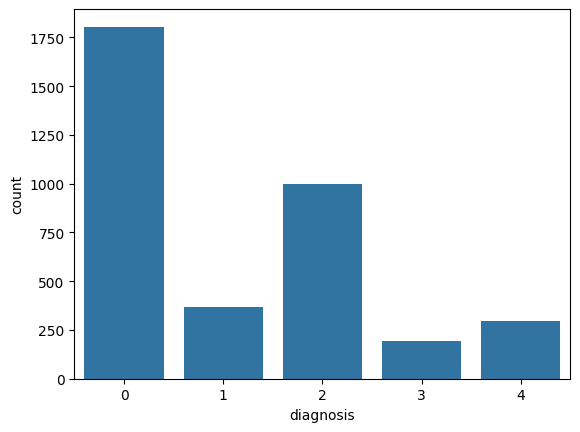

In [10]:
sns.countplot(combined_data,x='diagnosis')

In [11]:
image_dirs = [train_images,test_images,valid_images]
target_dir = "combined_images"
os.makedirs(target_dir, exist_ok=True)

for folder in image_dirs:
    for fname in os.listdir(folder):
        src = os.path.join(folder, fname)
        dst = os.path.join(target_dir, fname)
        if not os.path.exists(dst):
            shutil.copy2(src, dst)

In [12]:
target_size=500

In [13]:
data_downsampled=[]
for name,group in combined_data.groupby('diagnosis'):
  current_size=len(group)
  if current_size>target_size:
    data_downsampled.append(group.sample(target_size,random_state=42))
  else:
    data_downsampled.append(group)

downsampled_df=pd.concat(data_downsampled).reset_index(drop=True)
downsampled_df.head()

,id_code,diagnosis
0,ef5155990874,0
1,24de56d433cd,0
2,81914ceb4e74,0
3,a1b28bcbce00,0
4,c365c598ad4e,0


In [14]:
downsampled_df['diagnosis'].value_counts()

,count
diagnosis,
0,500
2,500
1,370
4,295
3,193


In [15]:
train_APTOS_df,val_test_APTOS_df=train_test_split(downsampled_df,test_size=0.2,random_state=42,stratify=downsampled_df['diagnosis'])
val_APTOS_df,test_APTOS_df=train_test_split(val_test_APTOS_df,test_size=0.5,random_state=42,stratify=val_test_APTOS_df['diagnosis'])

In [16]:
path = kagglehub.dataset_download("mariaherrerot/ddrdataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ddrdataset


In [19]:
list_dir = os.listdir(path)
images_path=os.path.join(path,list_dir[1],list_dir[1])
labels_path=os.path.join(path,list_dir[0])
print(images_path)
print(labels_path)

/kaggle/input/ddrdataset/DR_grading/DR_grading
/kaggle/input/ddrdataset/DR_grading.csv


In [20]:
labels_df=pd.read_csv(labels_path)
labels_df.head()

,id_code,diagnosis
0,20170413102628830.jpg,0
1,20170413111955404.jpg,0
2,20170413112015395.jpg,0
3,20170413112017305.jpg,0
4,20170413112528859.jpg,0


<Axes: xlabel='diagnosis', ylabel='count'>

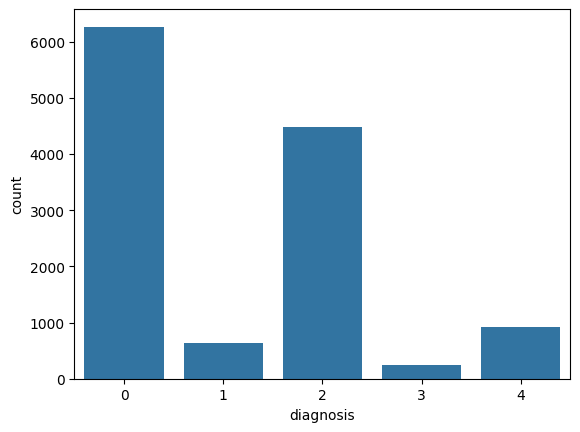

In [21]:
sns.countplot(x='diagnosis',data=labels_df)

In [22]:
labels_df['diagnosis'].value_counts()

,count
diagnosis,
0,6266
2,4477
4,913
1,630
3,236


In [23]:
size=800

In [24]:
new_data=[]
for name,group in labels_df.groupby('diagnosis'):
  targ_size=size-downsampled_df[downsampled_df['diagnosis']==name].shape[0]
  print(targ_size)
  if targ_size>0 :
    if targ_size>len(group):
      new_data.append(group)
    else:
      new_data.append(group.sample(targ_size,random_state=42))


300
430
300
607
505


In [25]:
collect_data=pd.concat(new_data).reset_index(drop=True)
collect_data.head()

,id_code,diagnosis
0,20170220085833145.jpg,0
1,20170329074906288.jpg,0
2,007-1981-100.jpg,0
3,007-0795-000.jpg,0
4,20170226223624346.jpg,0


In [26]:
train_DDR_df,val_test_DDR_df=train_test_split(collect_data,test_size=0.2,random_state=42,stratify=collect_data['diagnosis'])
val_DDR_df,test_DDR_df=train_test_split(val_test_DDR_df,test_size=0.5,random_state=42,stratify=val_test_DDR_df['diagnosis'])

In [27]:
for image in os.listdir(images_path):
  if image in collect_data['id_code'].values:
    src=os.path.join(images_path,image)
    dst=os.path.join(target_dir,image)
    if not os.path.exists(dst):
      shutil.copy2(src,dst)

In [28]:
train_df=pd.concat([train_APTOS_df,train_DDR_df]).reset_index(drop=True)
val_df=pd.concat([val_APTOS_df,val_DDR_df]).reset_index(drop=True)
test_df=pd.concat([test_APTOS_df,test_DDR_df]).reset_index(drop=True)

In [29]:
train_df['diagnosis'].value_counts()

,count
diagnosis,
1,640
0,640
2,640
4,640
3,342


In [30]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [31]:
class_weights=class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(train_df['diagnosis']),y=train_df['diagnosis'])
class_weights=torch.tensor(class_weights,dtype=torch.float).to(device)

In [32]:
class DDRDataset(Dataset):
    def __init__(self,images_path,labels, transform=None,mode='rgb_clahe'):
       self.images_path=images_path
       self.labels=labels
       self.transform=transform
       self.mode=mode

    def apply_clahe_rgb(self, image):
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))
        cl = clahe.apply(l)
        merged = cv2.merge((cl, a, b))
        return  merged

    def apply_green_clahe(self,image):
      green = image[:, :, 1]
      clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
      green_enhanced = clahe.apply(green)
      return cv2.merge([green_enhanced]*3)

    def apply_circular_mask(self,image):
      h, w = image.shape[:2]
      center = (w // 2, h // 2)
      radius = min(center[0], center[1])

      Y, X = np.ogrid[:h, :w]
      dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)
      mask = dist_from_center <= radius

      if image.ndim == 3:
          mask = np.stack([mask] * 3, axis=-1)

      masked_image = image.copy()
      masked_image[~mask] = 0
      return masked_image

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        image_name=self.labels.iloc[index,0]
        if '.' not in image_name:
            image_name=image_name+'.png'
        image_path=os.path.join(self.images_path,image_name)
        image=cv2.imread(image_path)
        if image is None:
            raise FileNotFoundError(f"Image not found at path: {image_path}")
        label=int(self.labels.iloc[index,1])
        label=torch.tensor(label).long()
        if self.mode=='rgb_clahe':
            image=self.apply_clahe_rgb(image)
            image=cv2.cvtColor(image, cv2.COLOR_LAB2RGB)
        elif self.mode=="lab_clahe":
          image=self.apply_clahe_rgb(image)

        elif self.mode=="green_clahe":
          image=self.apply_green_clahe(image)
        else:
          image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        #image=self.apply_circular_mask(image)
        if self.transform:
            image=self.transform(image)
        else:
            image=transforms.ToTensor()(image)
        return image,label


In [33]:
transforms_train=transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224),interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=[-180, 180],
                                fill=0,interpolation=transforms.InterpolationMode.BICUBIC),

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),

])
transforms_test=transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224),interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [34]:
train_data=DDRDataset(target_dir,train_df,transforms_train)
val_data=DDRDataset(target_dir,val_df,transforms_test)
test_data=DDRDataset(target_dir,test_df,transforms_test)
train_loader=DataLoader(train_data,batch_size=16,shuffle=True)
valid_loader=DataLoader(val_data,batch_size=16,shuffle=False)
test_loader=DataLoader(test_data,batch_size=16,shuffle=False)

In [35]:
def denormalize(img_tensor, mean, std):
    img_tensor = img_tensor.clone()
    for t, m, s in zip(img_tensor, mean, std):
        t.mul_(s).add_(m)
    return img_tensor


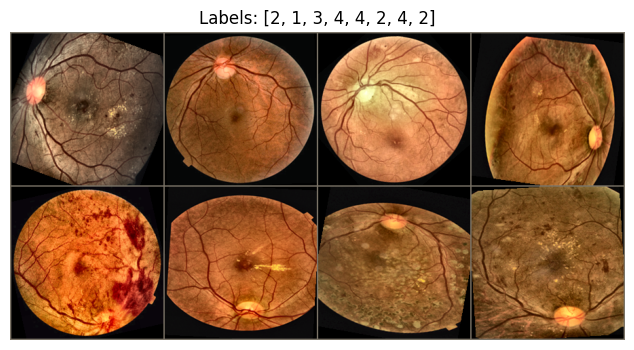

In [36]:
for images, labels in train_loader:
    grid_img =utils.make_grid(images[:8], nrow=4, padding=2)
    grid_img = denormalize(grid_img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    np_img = grid_img.permute(1, 2, 0).cpu().numpy()
    np_img = np_img.clip(0, 1)

    plt.figure(figsize=(10, 4))
    plt.imshow(np_img)
    plt.title(f"Labels: {labels[:8].tolist()}")
    plt.axis('off')
    plt.show()
    break

In [37]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, device,
                num_epochs=10, checkpoint_path="mobilenet_dr.pth",
                early_stopping_patience=5):

    best_val_loss = float('inf')
    epochs_no_improve = 0
    l_val_loss = []
    l_train_loss = []

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, verbose=True)

    for epoch in range(num_epochs):
        print(f"\nEpoch [{epoch+1}/{num_epochs}]")


        model.train()
        train_loss = 0.0
        train_correct = 0
        total = 0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            train_correct += (preds == labels).sum().item()
            total += labels.size(0)

        avg_train_loss = train_loss / total
        train_acc = train_correct / total
        l_train_loss.append(avg_train_loss)
        print(f"Train Loss: {avg_train_loss:.4f}, Accuracy: {train_acc:.4f}")
        model.eval()
        val_loss = 0.0
        val_correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in tqdm(valid_loader):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                preds = torch.argmax(outputs, dim=1)
                val_correct += (preds == labels).sum().item()
                total += labels.size(0)

        avg_val_loss = val_loss / total
        val_acc = val_correct / total
        l_val_loss.append(avg_val_loss)
        print(f"Val Loss: {avg_val_loss:.4f}, Accuracy: {val_acc:.4f}")


        scheduler.step(avg_val_loss)

        # Save best model and reset early stopping counter
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Saved checkpoint at epoch {epoch+1}")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"No improvement for {epochs_no_improve} epochs")

        # Check early stopping condition
        if epochs_no_improve >= early_stopping_patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    return l_train_loss, l_val_loss


In [38]:
def test_model(model, test_loader, criterion, device, num_classes=5):
    model.eval()

    accuracy = Accuracy(task="multiclass", num_classes=num_classes).to(device)
    precision = Precision(task="multiclass", num_classes=num_classes, average='weighted').to(device)
    recall = Recall(task="multiclass", num_classes=num_classes, average='weighted').to(device)
    f1 = F1Score(task="multiclass", num_classes=num_classes, average='weighted').to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            accuracy.update(preds, labels)
            precision.update(preds, labels)
            recall.update(preds, labels)
            f1.update(preds, labels)

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
    print(f"Accuracy: {accuracy.compute().item():.4f}")
    print(f"Precision (weighted): {precision.compute().item():.4f}")
    print(f"Recall (weighted): {recall.compute().item():.4f}")
    print(f"F1 Score (weighted): {f1.compute().item():.4f}")

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, digits=3))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    accuracy.reset()
    precision.reset()
    recall.reset()
    f1.reset()

In [57]:
num_classes=5
model=models.mobilenet_v2(pretrained=True)
print(model)
model.classifier[1]=nn.Linear(model.last_channel,num_classes)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [58]:
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
l_train_loss,l_val_loss=train_model(model, train_loader, valid_loader, criterion, optimizer, device, num_epochs=10)


Epoch [1/10]


100%|██████████| 182/182 [10:05<00:00,  3.33s/it]


Train Loss: 1.3228, Accuracy: 0.4562


100%|██████████| 23/23 [00:47<00:00,  2.07s/it]


Val Loss: 1.1600, Accuracy: 0.5758
Saved checkpoint at epoch 1

Epoch [2/10]


100%|██████████| 182/182 [09:52<00:00,  3.26s/it]


Train Loss: 1.1913, Accuracy: 0.5717


100%|██████████| 23/23 [00:46<00:00,  2.02s/it]


Val Loss: 1.1019, Accuracy: 0.6336
Saved checkpoint at epoch 2

Epoch [3/10]


100%|██████████| 182/182 [09:53<00:00,  3.26s/it]


Train Loss: 1.1106, Accuracy: 0.6210


100%|██████████| 23/23 [00:45<00:00,  1.99s/it]


Val Loss: 1.0479, Accuracy: 0.6419
Saved checkpoint at epoch 3

Epoch [4/10]


100%|██████████| 182/182 [09:56<00:00,  3.28s/it]


Train Loss: 1.0920, Accuracy: 0.6189


100%|██████████| 23/23 [00:46<00:00,  2.00s/it]


Val Loss: 1.0255, Accuracy: 0.6501
Saved checkpoint at epoch 4

Epoch [5/10]


100%|██████████| 182/182 [09:59<00:00,  3.29s/it]


Train Loss: 1.0665, Accuracy: 0.6502


100%|██████████| 23/23 [00:50<00:00,  2.21s/it]


Val Loss: 1.0622, Accuracy: 0.6446
No improvement for 1 epochs

Epoch [6/10]


100%|██████████| 182/182 [10:04<00:00,  3.32s/it]


Train Loss: 1.0471, Accuracy: 0.6623


100%|██████████| 23/23 [00:46<00:00,  2.03s/it]


Val Loss: 1.0219, Accuracy: 0.6832
Saved checkpoint at epoch 6

Epoch [7/10]


100%|██████████| 182/182 [10:07<00:00,  3.34s/it]


Train Loss: 1.0333, Accuracy: 0.6647


100%|██████████| 23/23 [00:45<00:00,  1.99s/it]


Val Loss: 1.0024, Accuracy: 0.6942
Saved checkpoint at epoch 7

Epoch [8/10]


100%|██████████| 182/182 [10:00<00:00,  3.30s/it]


Train Loss: 1.0227, Accuracy: 0.6737


100%|██████████| 23/23 [00:46<00:00,  2.03s/it]


Val Loss: 0.9793, Accuracy: 0.6832
Saved checkpoint at epoch 8

Epoch [9/10]


100%|██████████| 182/182 [10:00<00:00,  3.30s/it]


Train Loss: 0.9957, Accuracy: 0.6971


100%|██████████| 23/23 [00:46<00:00,  2.01s/it]


Val Loss: 1.0538, Accuracy: 0.6749
No improvement for 1 epochs

Epoch [10/10]


100%|██████████| 182/182 [10:03<00:00,  3.31s/it]


Train Loss: 0.9851, Accuracy: 0.6930


100%|██████████| 23/23 [00:45<00:00,  2.00s/it]

Val Loss: 1.0592, Accuracy: 0.6942
No improvement for 2 epochs


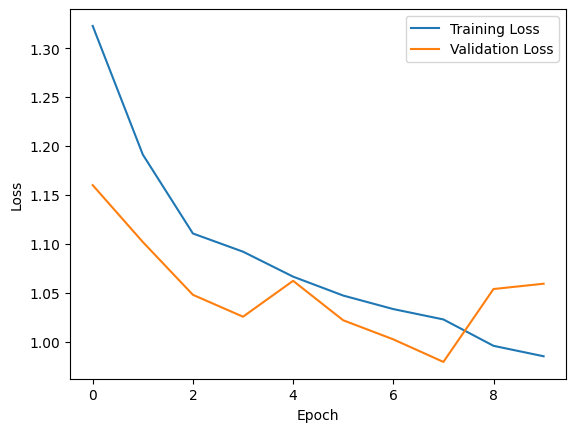

In [ ]:
plt.plot(l_train_loss, label='Training Loss')
plt.plot(l_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model.load_state_dict(torch.load("mobilenet_dr.pth"))
l_train_loss,l_val_loss=train_model(model, train_loader, valid_loader, criterion, optimizer, device, num_epochs=5)


Epoch [1/5]


100%|██████████| 182/182 [10:14<00:00,  3.38s/it]


Train Loss: 0.9879, Accuracy: 0.6988


100%|██████████| 23/23 [00:45<00:00,  1.99s/it]


Val Loss: 0.9966, Accuracy: 0.6915
Saved checkpoint at epoch 1

Epoch [2/5]


100%|██████████| 182/182 [10:06<00:00,  3.33s/it]


Train Loss: 0.9890, Accuracy: 0.6881


100%|██████████| 23/23 [00:46<00:00,  2.01s/it]


Val Loss: 1.0021, Accuracy: 0.6749
No improvement for 1 epochs

Epoch [3/5]


100%|██████████| 182/182 [10:05<00:00,  3.33s/it]


Train Loss: 0.9655, Accuracy: 0.7102


100%|██████████| 23/23 [00:46<00:00,  2.01s/it]


Val Loss: 1.0572, Accuracy: 0.6612
No improvement for 2 epochs

Epoch [4/5]


100%|██████████| 182/182 [10:06<00:00,  3.34s/it]


Train Loss: 0.9294, Accuracy: 0.7257


100%|██████████| 23/23 [00:46<00:00,  2.00s/it]


Val Loss: 0.9897, Accuracy: 0.7135
Saved checkpoint at epoch 4

Epoch [5/5]


100%|██████████| 182/182 [10:05<00:00,  3.33s/it]


Train Loss: 0.9236, Accuracy: 0.7305


100%|██████████| 23/23 [00:45<00:00,  1.99s/it]

Val Loss: 0.9925, Accuracy: 0.7025
No improvement for 1 epochs


100%|██████████| 23/23 [00:55<00:00,  2.41s/it]


Accuracy: 0.6731
Precision (weighted): 0.6891
Recall (weighted): 0.6731
F1 Score (weighted): 0.6777

Classification Report:
              precision    recall  f1-score   support

           0      0.870     0.838     0.854        80
           1      0.672     0.562     0.612        80
           2      0.510     0.613     0.557        80
           3      0.509     0.614     0.557        44
           4      0.803     0.713     0.755        80

    accuracy                          0.673       364
   macro avg      0.673     0.668     0.667       364
weighted avg      0.689     0.673     0.678       364



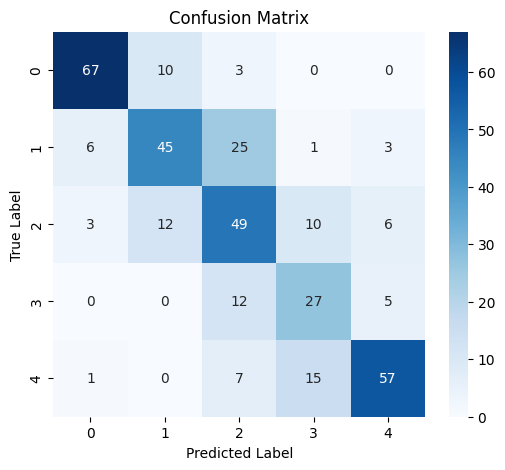

In [ ]:
model.load_state_dict(torch.load("mobilenet_dr.pth"))
test_model(model, test_loader, criterion, device)

In [ ]:
model.load_state_dict(torch.load("/content/mobilenet_dr_last.pth"))
l_train_loss,l_val_loss=train_model(model, train_loader, valid_loader, criterion, optimizer, device, num_epochs=10)


Epoch [1/10]


100%|██████████| 182/182 [21:44<00:00,  7.17s/it]


Train Loss: 0.9421, Accuracy: 0.7257


100%|██████████| 23/23 [01:30<00:00,  3.94s/it]


Val Loss: 0.9899, Accuracy: 0.6804
Saved checkpoint at epoch 1

Epoch [2/10]


100%|██████████| 182/182 [21:28<00:00,  7.08s/it]


Train Loss: 0.9166, Accuracy: 0.7340


100%|██████████| 23/23 [01:33<00:00,  4.07s/it]


Val Loss: 1.0440, Accuracy: 0.6915
No improvement for 1 epochs

Epoch [3/10]


100%|██████████| 182/182 [21:41<00:00,  7.15s/it]


Train Loss: 0.9007, Accuracy: 0.7447


100%|██████████| 23/23 [01:30<00:00,  3.93s/it]


Val Loss: 0.9822, Accuracy: 0.6804
Saved checkpoint at epoch 3

Epoch [4/10]


100%|██████████| 182/182 [21:40<00:00,  7.14s/it]


Train Loss: 0.8902, Accuracy: 0.7540


100%|██████████| 23/23 [01:32<00:00,  4.01s/it]


Val Loss: 1.0292, Accuracy: 0.6777
No improvement for 1 epochs

Epoch [5/10]


100%|██████████| 182/182 [21:52<00:00,  7.21s/it]


Train Loss: 0.8788, Accuracy: 0.7657


100%|██████████| 23/23 [01:32<00:00,  4.01s/it]


Val Loss: 1.0909, Accuracy: 0.6722
No improvement for 2 epochs

Epoch [6/10]


100%|██████████| 182/182 [21:41<00:00,  7.15s/it]


Train Loss: 0.8618, Accuracy: 0.7622


100%|██████████| 23/23 [01:31<00:00,  3.98s/it]


Val Loss: 1.1111, Accuracy: 0.6529
No improvement for 3 epochs

Epoch [7/10]


100%|██████████| 182/182 [21:51<00:00,  7.21s/it]


Train Loss: 0.8126, Accuracy: 0.7988


100%|██████████| 23/23 [01:41<00:00,  4.41s/it]


Val Loss: 1.0417, Accuracy: 0.6915
No improvement for 4 epochs

Epoch [8/10]


100%|██████████| 182/182 [22:15<00:00,  7.34s/it]


Train Loss: 0.7887, Accuracy: 0.8181


100%|██████████| 23/23 [01:31<00:00,  3.97s/it]

Val Loss: 1.0408, Accuracy: 0.6915
No improvement for 5 epochs
Early stopping triggered at epoch 8


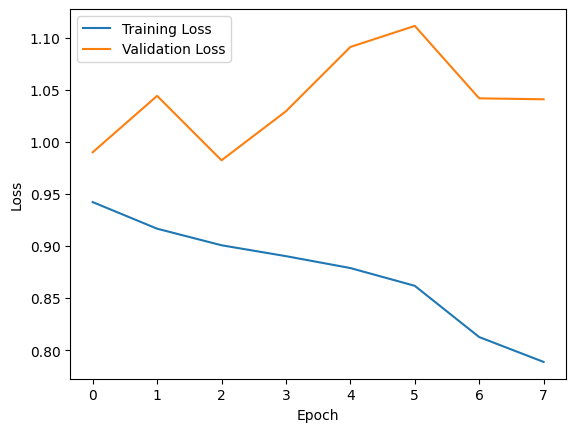

In [ ]:
plt.plot(l_train_loss, label='Training Loss')
plt.plot(l_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

100%|██████████| 23/23 [01:36<00:00,  4.18s/it]


Accuracy: 0.6703
Precision (weighted): 0.6843
Recall (weighted): 0.6703
F1 Score (weighted): 0.6726

Classification Report:
              precision    recall  f1-score   support

           0      0.812     0.863     0.836        80
           1      0.716     0.600     0.653        80
           2      0.547     0.512     0.529        80
           3      0.455     0.682     0.545        44
           4      0.789     0.700     0.742        80

    accuracy                          0.670       364
   macro avg      0.664     0.671     0.661       364
weighted avg      0.684     0.670     0.673       364



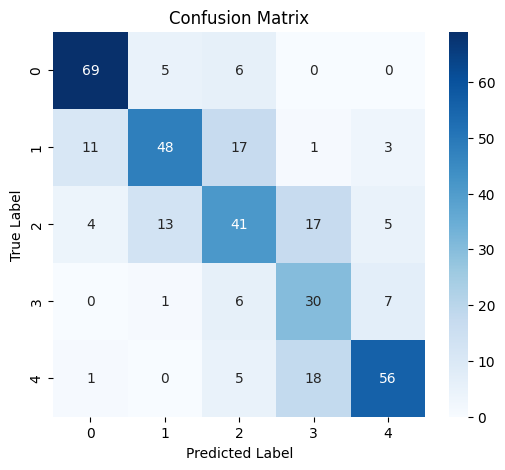

In [ ]:
model.load_state_dict(torch.load("mobilenet_dr.pth"))
test_model(model, test_loader, criterion, device)